In [1]:
import torch
import numpy as np
import sklearn
import pickle

import torch.optim as optim

from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt

from src.dataset_segmented import AnimeAudioDataset

device = torch.device("cuda")

## Load Data

In [2]:
# Load data and train/val split
data = AnimeAudioDataset(l96=False)

valid_len = len(data) // 5
train_len = len(data) - valid_len
valid, train = torch.utils.data.random_split(data, [valid_len, train_len])

In [3]:
# Extract data into list
X_train = [t[0].cpu().numpy().tolist() for t in train]
y_train = [t[1] for t in train]

X_valid = [t[0].cpu().numpy().tolist() for t in valid]
y_valid = [t[1] for t in valid]

## Load Adaboost Model

In [4]:
filename = 'adaboost.sav'
clf = pickle.load(open(filename, 'rb'))

## Preprocess

In [5]:
# Convert feature from raw to the adaboost prediction
X_train = [clf.predict(X) for X in X_train]
X_valid = [clf.predict(X) for X in X_valid]

In [6]:
# Convert negative clips to -1
X_train = [((X != 1).astype(int) * -1) + X for X in X_train]
X_valid = [((X != 1).astype(int) * -1) + X for X in X_valid]

## Manual Edge Detector 

In [11]:
def get_edge(x, start=True, kernel_len=120, num_selected=5):
    
    assert kernel_len % 2 == 0 # kernel length should be even
    
    if start:
        kernel = ([-1] * int(kernel_len / 2)) + ([1] * int(kernel_len / 2))
    else:
        kernel = ([1] * int(kernel_len / 2)) + ([-1] * int(kernel_len / 2))
    
    # pad both sides with half of kernel
    pad = np.array([-1] * int(kernel_len / 2))
    x_padded = np.hstack((pad, x, pad))
    
    heap = []
    
    for i in range(len(x_padded) - kernel_len):
        val = np.dot(x_padded[i:i + kernel_len], kernel)
        
        # maintain heap of best (value, index) pair based on value
        heap.append((val, i))
        heap = sorted(heap, reverse=True, key=lambda x: x[0])
        if len(heap) > num_selected:
            heap.pop()
        
    return heap

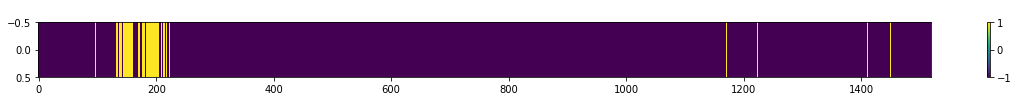

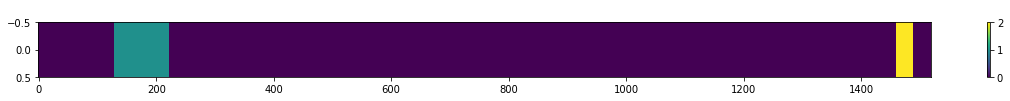

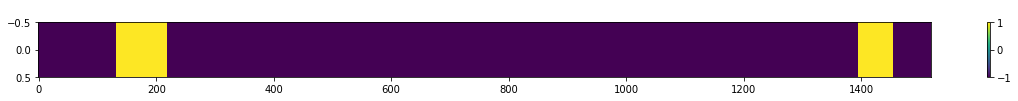

In [33]:
plt.rcParams["figure.figsize"] = (20,1)

fn = 'Shingeki_no_Kyojin_1'
y = clf.predict(data.features[fn].cpu().numpy())
y = ((y != 1).astype(int) * -1) + y

plt.title('predict')
plt.imshow(y.reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

plt.title('actual')
plt.imshow(data.labels96[fn].cpu().numpy().reshape((1,-1)), aspect='auto')
plt.colorbar()
plt.show()

y_start, y_end = y[:int(len(y) * 0.75)], y[int(len(y) * 0.75):]

intro_start = get_edge(y_start, start=True)
outro_start = get_edge(y_end, start=True)
intro_end = get_edge(y_start, start=False)
outro_end = get_edge(y_end, start=False)

outro_start = [(val, idx + len(y_start)) for (val, idx) in outro_start]
outro_end = [(val, idx + len(y_start)) for (val, idx) in outro_end]

intro_start_single = intro_start[0][1]
intro_end_single = intro_end[0][1]
outro_start_single = outro_start[0][1]
outro_end_single = outro_end[0][1]

predicted = []
for i in range(len(y)):
    if i >= intro_start_single and i < intro_end_single:
        predicted.append(1)
    elif i >= outro_start_single and i < outro_end_single:
        predicted.append(1)
    else:
        predicted.append(-1)

plt.title('predicted')
plt.imshow(np.array(predicted).reshape((1, -1)), aspect='auto')
plt.colorbar()
plt.show()

# print(f"Intro Start: {intro_start_single}")
# print(f"Intro End: {intro_end_single}")
# print(f"Outro Start: {outro_start_single}")
# print(f"Outro End: {outro_end_single}")

In [51]:
# input is output of adaboost
def get_edges(y):
    
    y = ((y != 1).astype(int) * -1) + y
    y_start, y_end = y[:int(len(y) * 0.75)], y[int(len(y) * 0.75):]

    intro_start = get_edge(y_start, start=True)
    outro_start = get_edge(y_end, start=True)
    intro_end = get_edge(y_start, start=False)
    outro_end = get_edge(y_end, start=False)

    outro_start = [(val, idx + len(y_start)) for (val, idx) in outro_start]
    outro_end = [(val, idx + len(y_start)) for (val, idx) in outro_end]

    intro_start_single = intro_start[0][1]
    intro_end_single = intro_end[0][1]
    outro_start_single = outro_start[0][1]
    outro_end_single = outro_end[0][1]
    
    intro_score = intro_start[0][0] + intro_end[0][0]
    outro_score = outro_start[0][0] + outro_end[0][0]
    
    predicted = []
    for i in range(len(y)):
        if intro_score > 140 and i >= intro_start_single and i < intro_end_single:
            predicted.append(1)
        elif outro_score > 140 and i >= outro_start_single and i < outro_end_single:
            predicted.append(1)
        else:
            predicted.append(-1)
            
    return predicted

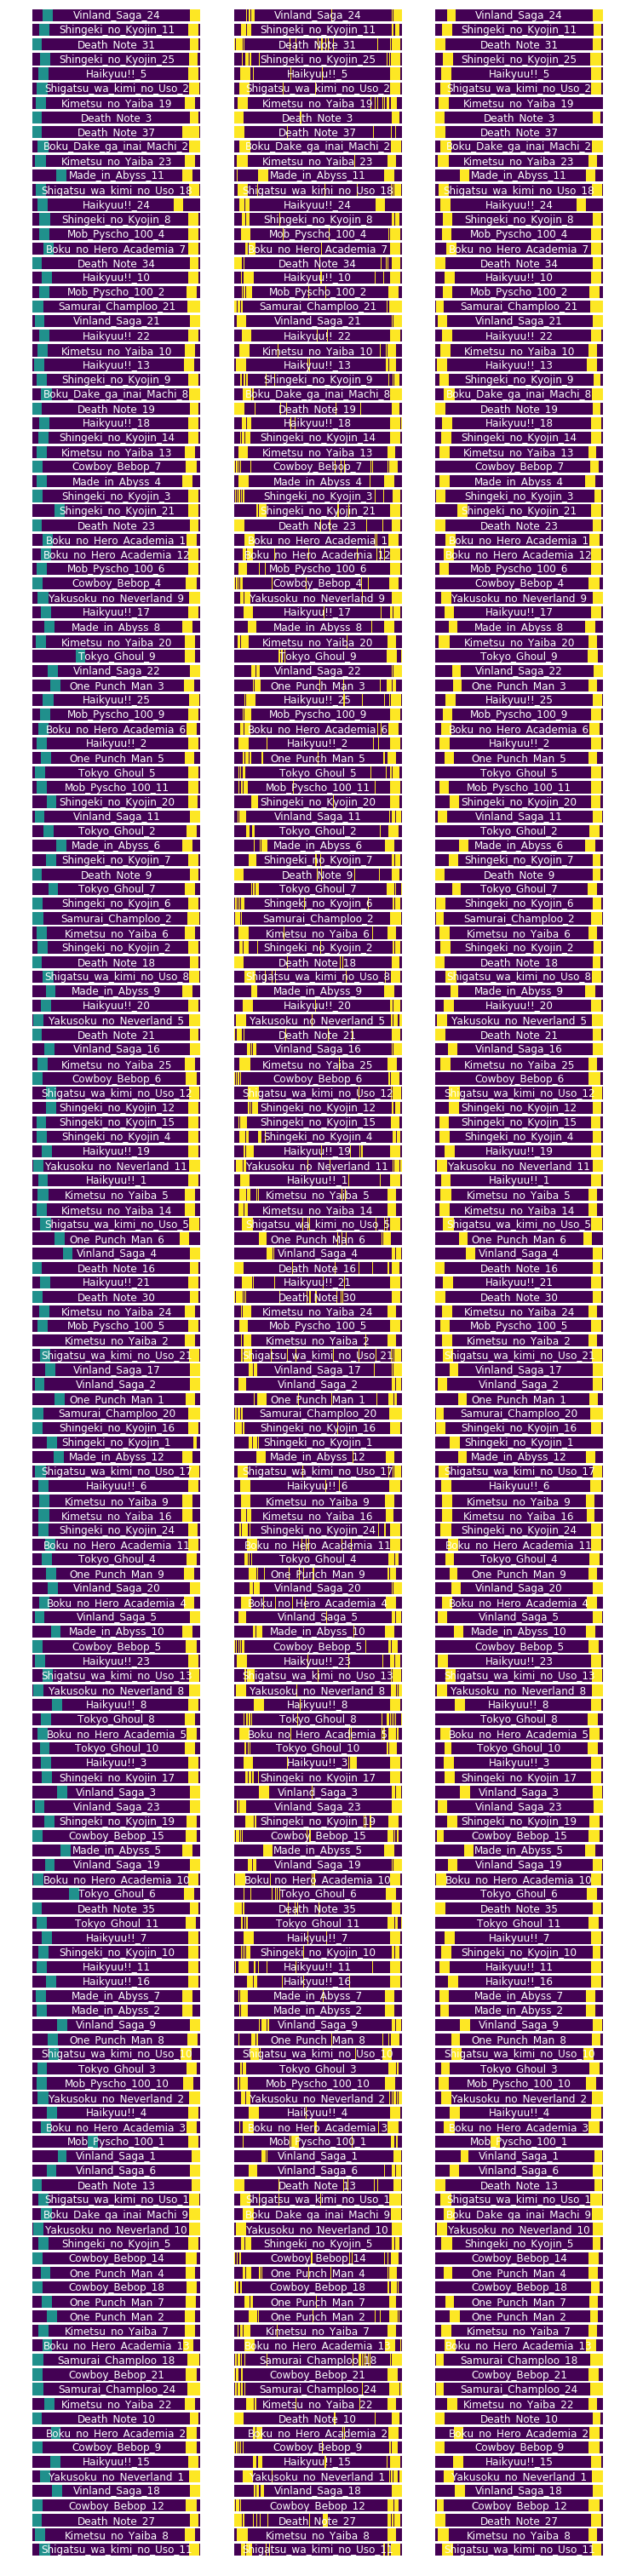

In [52]:
width = 12
height = 55

plt.rcParams["figure.figsize"] = (width, height)
plt.rcParams['text.color'] = 'white'
axes = []
fig = plt.figure()

for i, a in enumerate(data.features):
    
    pred = clf.predict(data.features[a])
    predicted = get_edges(pred)
    
    axes.append(fig.add_subplot(len(data.features), 3, (i*3) + 1))
    axes[-1].set_title(a, y=-.2)
    plt.imshow(data.labels96[a].cpu().numpy().reshape((1,-1)), aspect='auto')
    plt.axis('off')
    
    axes.append(fig.add_subplot(len(data.features), 3, (i*3) + 2))
    axes[-1].set_title(a, y=-.2)
    plt.imshow(np.array(pred).reshape((1,-1)), aspect='auto')
    plt.axis('off')
    
    axes.append(fig.add_subplot(len(data.features), 3, (i*3) + 3))
    axes[-1].set_title(a, y=-.2)
    plt.imshow(np.array(predicted).reshape((1,-1)), aspect='auto')
    plt.axis('off')

plt.show()